# Recurrent Neural Network forecasting 

- Reference:`keras.layers.SimpleRNN`

**Basic Architecture diagram**  

<img src="./pic/RNN.png" alt="RNN Architecture" width="500"/>

- U,V,W are weight matrix.
- Input: vector $X_t$ is input for network at time step t.  
- Hidden state: vector $h(t)=\tanh \left(W h(t-1)+U_{x}(t)\right)$
- Output: $y_t$ is the output for the network at time step t. $y_t=\operatorname{softmax}(V s(t))$

Every neuron is assigned to a fixed step. The output of the hidden layer of one time step is part of the input of next time step.

- The algorithm is to find the optimal weight matrix U,V,W that gives the best prediction or minimizes the loss function $J$. 
$$J(\theta)=\frac{1}{m} \sum_{i=1}^{m} \sum_{t=1}^{N_{i}} D(y_t, Y_t)$$
- Forward/Backward propagation

## Vanishing gradiant problems 

- LSTM `keras.layers.LSTM`, first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
- GRU `keras.layers.GRU`, first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).

## RNN-LSTM Crypto-forcasting 
- Thanks to [jeffheaton](https://github.com/jeffheaton/t81_558_deep_learning)

In [4]:
import os
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import metrics

print(tf.__version__)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

##data and date
csv_path = '/Users/dingxian/Documents/GitHub/Crypto_Forecasting_kaggle/codetest/btc.csv'
df = pd.read_csv(csv_path)
df = df[-70000:]
date_time = pd.to_datetime(df.pop('timestamp'),unit='s')

df = df[['Count','Open','High','Low','Close','Volume','VWAP']]

2.6.0
Num GPUs Available:  1


## Split the data

split for the training(70%), validation(20%), and test sets(10%). See section **overfitting**.

In [5]:
from sklearn.model_selection import train_test_split
#train, validation sets
train_df,val_df = train_test_split(df,train_size=0.70,test_size=0.20,shuffle=False)
#holdout/test sets
n = len(df) #rows
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalize the data
scale features before training a neural network

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std #scipy.stats.zscore(train_df,ddof=1)
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


## Data for LSTM: windowing and prediction conditions

The models make a set of predictions based on a window of consecutive samples from the data.
- The `width` (number of time steps) of the `input` and `label` windows.
- The `shift=offset` between them.
- Which `features` are used as `inputs`, `labels`, or both.

Example: to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:
<img src="./pic/raw_window_24h.png" alt="window24_24" width="500"/>



The data used for training the model is formated as `tf.data.Dataset` which is splited into inputs and labels. Similarly for valuation, test and example data.

## Long Short-Term Memory  
<img src="./pic/LSTM-1.png" alt="LSTM Architecture" width="500"/> 

- [https://keras.io](https://keras.io)
- ` tf.keras.layers.LSTM`
- `return_sequence=True`, it will return something with shape: `(batch_size, timespan, unit)`. 
- `return_sequence=False`, then it just return the last output in shape `(batch_size, unit)`.


### Model Design
- `LSTM(units = 20)`: LSTM layer with 20 internal units.
- `Dense(units=2)`: Dense layer with 2 units.
    dense models handled each time step independently.
- Choose units by cross validation.

Graph below demonstrates what layer and unit (or neuron) are, and the rightmost image shows the internal structure of a single LSTM unit.
<img src="./pic/lstm-units.png" alt="lstmunits" width="500"/>

In [7]:
from script.RNN.myModel import modelcandidate
wide_window,lstm_model = modelcandidate(input_width=30, label_width=30, shift=1,
                                                train_df=train_df, val_df=val_df, test_df=test_df,
                                                label_columns=['Close'])
IPython.display.clear_output()

In [8]:
print('Input shape:', wide_window.example[0].shape)#[batch_size, timesteps, feature]
print('Output shape:', lstm_model(inputs= wide_window.example[0]).shape)
print('Label shape:', wide_window.example[1].shape)

Input shape: (32, 30, 7)
Output shape: (32, 30, 1)
Label shape: (32, 30, 1)


### Visualization the architecture
- `lstm_model.summary()`
- Graphs dashboard

```python
#Op-level graph
%tensorboard --logdir logs
```

In [9]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 20)            2240      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 1)             21        
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
_________________________________________________________________


### Performance metric

In [11]:
val_performance={}
performance={}
val_performance['LSTM0'] = lstm_model.evaluate(x = wide_window.val,verbose=0)
performance['LSTM0'] = lstm_model.evaluate(wide_window.test, verbose=0,return_dict=False)
lstm_model.metrics_names

['loss', 'mean_absolute_error', 'mse']

In [12]:
performance['LSTM0']#test evaluation

[0.013909155502915382, 0.1099785566329956, 0.013909154571592808]

In [13]:
val_performance['LSTM0']#val/train evaluation

[0.006963009480386972, 0.0573078952729702, 0.0069630080834031105]

Use prediction to calculate the metrics as above:  

```python
import itertools

pred = []
label = []
for input_batch,label_batch in wide_window.test:
    pred_batch = lstm_model(input_batch)
    pred.append(list(pred_batch.numpy().flatten()))
    label.append(list(label_batch.numpy().flatten()))


#flatten list of lists
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))
#sklearn version
print(metrics.mean_absolute_error(label, pred), metrics.mean_squared_error(label, pred))

#tf.keras.loss version
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
print(mae(label, pred).numpy(), mse(label, pred).numpy()) 



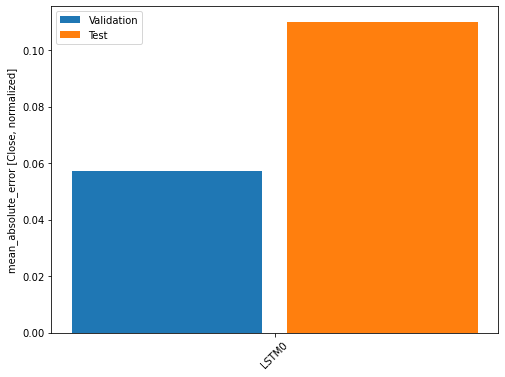

In [14]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
mae_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[mae_index] for v in val_performance.values()]
test_mae = [v[mae_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## Save the trained LSTM

```
# save neural network structure to JSON (no weights)
model_json = lstm_model.to_json()
with open(os.path.join(save_path,"network.json"), "w") as json_file:
    json_file.write(model_json)

# save neural network structure to YAML (no weights)
model_yaml = lstm_model.to_yaml()
with open(os.path.join(save_path,"network.yaml"), "w") as yaml_file:
    yaml_file.write(model_yaml)

```

In [15]:
# save entire network to HDF5 (save everything, suggested)
save_path = "./trainedNN"
lstm_model.save(os.path.join(save_path,"lstm-notebook.h5"))

In [17]:
# reload
save_path = "./trainedNN"
lstm_model_reload = tf.keras.models.load_model(os.path.join(save_path,"lstm-notebook.h5"))

# Tuning hyperparameters

Some of the hyperparameters seen so far include:

* Number of layers in the neural network
* How many neurons in each layer
* What activation functions to use on each layer
* Dropout percent on each layer
* L1 and L2 values on each layer

## Overfitting and Early Stopping 

It is important to segment the original dataset into several datasets(already done in the previous section):

* **Training Set** : `wide_window.train`
* **Validation Set** : `wide_window.val`
* **Holdout Set**: `wide_window.test`

The training data(`wide_window.train`) are used to train the neural network until the validation set no longer improves.  This attempts to stop at a near optimal training point.  This method will only give accurate "**out of sample**" predictions for the validation set(`wide_window.val`), this is usually 20% or so of the data.  The predictions for the training data will be overly optimistic, as these were the data that the neural network was trained on.

I design this data split method in the class `WindowGenerator` as shown in section data windowing. The model fitting takes the early stopping through `tf.keras.callbacks.EarlyStopping`.

I design the earlystopping based on validation set as:

```python
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',restore_best_weights=False)
```

- details: [https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

## K-fold CrossValidation for hyperparameters
- reference:[https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning))  

- K-fold for sectional data: `sklearn.model_selection.KFold`
- K-fold for time series needs rolling basis: `sklearn.model_selection.TimeSeriesSplit`
- K-fold for time series needs blocking rolling basis:[https://goldinlocks.github.io/Time-Series-Cross-Validation/](https://goldinlocks.github.io/Time-Series-Cross-Validation/)

<img src="./pic/class_1_kfold.png" alt="RNN Architecture" width="500"/>

(11670, 7) (11666, 7)
(23336, 7) (11666, 7)
(35002, 7) (11666, 7)
(46668, 7) (11666, 7)
(58334, 7) (11666, 7)


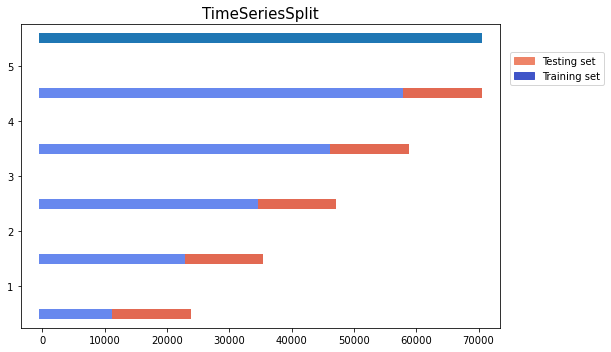

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from script.RNN.kfoldwindow import plot_cv_indices
tscv = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tscv.split(X=df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    print(cv_train.shape,cv_test.shape)

plot_cv_indices(tscv,X=df)

(7000, 7) (7000, 7)
(7000, 7) (7000, 7)
(7000, 7) (7000, 7)
(7000, 7) (7000, 7)
(7000, 7) (7000, 7)


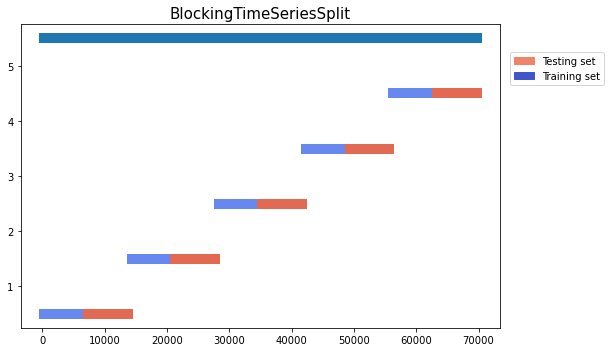

In [19]:
from script.RNN.kfoldwindow import BlockingTimeSeriesSplit, plot_cv_indices
tscv = BlockingTimeSeriesSplit(n_splits = 5, X=df)
for train_index, test_index in tscv.split(X=df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    print(cv_train.shape,cv_test.shape)
plot_cv_indices(tscv, X=tscv.X)

### Training with both a Cross-Validation and a Holdout Set

```PYTHON
from script.RNN.kfoldwindow import BlockingTimeSeriesSplit, plot_cv_indices
import tensorflow as tf
from script.RNN.window import WindowGenerator
from script.RNN.compilefit import compile_and_fit
from script.RNN.kfoldprocess import blockkfoldcv
import itertools

#holdout/test sets
n = len(df)
test_df = df[int(n*0.9):]

tscv = BlockingTimeSeriesSplit(n_splits = 5,X=df[:int(n*0.9)])
fold = 0
oos_y = []
oos_pred = []
fold_score=[]
#k-fold loop
for train_index, val_index in tscv.split():
    fold+=1
    print(f"Fold #{fold}")
    #train, validation sets
    cv_train, cv_val = df.iloc[train_index], df.iloc[val_index]
    num_features = df.shape[1]
    #normalization
    train_mean = cv_train.mean()
    train_std = cv_train.std()
    cv_train = (cv_train - train_mean) / train_std #scipy.stats.zscore(train_df,ddof=1)
    cv_val = (cv_val - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    # windowing
    wide_window = WindowGenerator(
        input_width=30, label_width=30, shift=1,train_df=cv_train, val_df=cv_val, test_df=test_df,
        label_columns=['Close'])
    # model design
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(units = 20, return_sequences=True,
                            activation='tanh', recurrent_activation='sigmoid'),#Recurrent layers
        tf.keras.layers.Dense(units=1)#densely-connected NN layer: output with dim-1
    ])
    # fit the model
    history = compile_and_fit(model = lstm_model, window = wide_window, 
                            MAX_EPOCHS = 2)
    #Measure RMSE error for this fold
    score = lstm_model.evaluate(wide_window.val, verbose=0,return_dict=True)
    fold_score.append(score)
    print(f"Fold score (MSE): {score['mse']}")

    # prediction on validation set
    pred = []
    label = []
    for input_batch,label_batch in wide_window.val:
        pred_batch = lstm_model(input_batch)
        pred.append(list(pred_batch.numpy().flatten()))
        label.append(list(label_batch.numpy().flatten()))
    #flatten list of lists
    pred = np.array(list(itertools.chain(*pred)))
    label = np.array(list(itertools.chain(*label)))
    oos_y.append(label)
    oos_pred.append(pred) 
    

IPython.display.clear_output()
fold_score
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print(f"Final, out of sample score (RMSE): {score}")  
```

In [20]:
from script.RNN.kfoldprocess import blockkfoldcv
score = blockkfoldcv(df = df, K=3,withholdout=True,holdoutpct=0.1)
IPython.display.clear_output()

print(f"Final, out of sample score (RMSE): {score}")  

Final, out of sample score (RMSE): 0.2533496916294098


In [ ]:
# Write the cross-validated prediction (from the last neural network in the k-fold above)
# prediction on test/holdout set
pred = []
label = []
for input_batch,label_batch in wide_window.test:
    pred_batch = lstm_model(input_batch)
    pred.append(list(pred_batch.numpy().flatten()))
    label.append(list(label_batch.numpy().flatten()))
#flatten list of lists
pred = np.array(list(itertools.chain(*pred)))
label = np.array(list(itertools.chain(*label)))


score = np.sqrt(metrics.mean_squared_error(pred,label))
print(f"Holdout score (RMSE): {score}")  

## L1 and L2 Regularization to Decrease Overfitting
- `kernel_regularizer`: Regularizer to apply a penalty on the layer's kernel
- `bias_regularizer`: Regularizer to apply a penalty on the layer's bias
- `activity_regularizer`: Regularizer to apply a penalty on the layer's output

In [ ]:
from tensorflow.keras import regularizers
# model design with l2 regulizers
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 20, return_sequences=True,activity_regularizer=regularizers.l2(1e-5),
                        activation='tanh', recurrent_activation='sigmoid'),#Recurrent layers
    tf.keras.layers.Dense(units=1)#densely-connected NN layer: output with dim-1
])


## Drop Out for Keras to Decrease Overfitting

Dropout works by causing hidden neurons of the neural network to be unavailable during part of the training.  Dropping part of the neural network causes the remaining portion to be trained to still achieve a good score even without the dropped neurons.  This decreases coadaption between neurons, which results in less overfitting. 

In [ ]:
from tensorflow.keras.layers import Dropout

## Bootstrapping(other than cross-validation)

Use Bootstrapping for hyperparameter benchmarking.  

* Number of layers in the neural network
* How many neurons in each layer
* What activation functions to use on each layer
* Dropout percent on each layer
* L1 and L2 values on each layer


To try out each of these **hyperparameters** you will need to run train neural networks with multiple settings for each hyperparameter.  However, you may have noticed that neural networks often produce somewhat different results when trained multiple times.  This is because the neural networks start with random weights.  Because of this it is necessary to fit and evaluate a neural network times to ensure that one set of hyperparameters are actually better than another.  **Bootstrapping** can be an effective means of benchmarking (comparing) two sets of hyperparameters. 

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

For time series we need block bootstrapping

## Bayesian Hyperparameter Optimization for Keras  

Bayesian Hyperparameter Optimization is a method of finding hyperparameters in a more efficient way than a grid search.  Because each candidate set of hyperparameters requires a retraining of the neural network, it is best to keep the number of candidate sets to a minimum. Bayesian Hyperparameter Optimization achieves this by training a model to predict good candidate sets of hyperparameters.

In [ ]:
from bayes_opt import BayesianOptimization

# Building Ensembles: methods for quantifying variable importance